In [1]:
import numpy as np
import pandas as pd
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import copy

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
x = pickle.load(open("HargaSaham.dat", "rb"))   # data harga saham sebanyak 250 observasi.
N = x.shape[0]

pd.DataFrame(x).head()

,0
0,130.883893
1,131.079758
2,131.437295
3,129.094033
4,128.009200


In [3]:
pd.DataFrame(x).describe()

,0
count,250.000000
mean,129.893804
std,4.141466
min,120.302504
25%,126.764918
50%,129.791001
75%,132.864101
max,139.100095


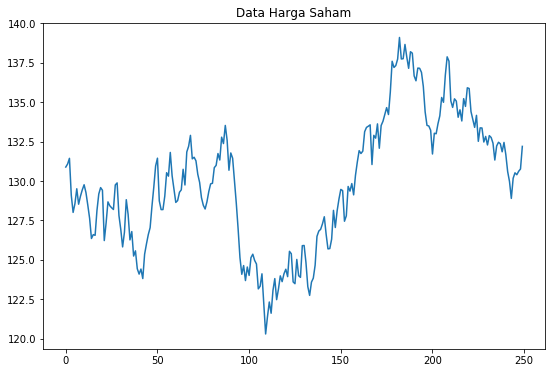

In [4]:
# Plot data
plt.figure(figsize=(9,6))
plt.plot(x)
plt.title("Data Harga Saham")
plt.show()

In [5]:
# Standarisasi
xs = (x-x.min())/(x.max()-x.min())   # Standarisasi data

step = 2   # step atau lag data diwaktu sebelumnya sebagai input
xt = xs[0:N-step,:]
for i in range(step):
    xt = hstack((xt, xs[i+1:N-step+i+1]))   # Dihasilkan matriks dengan (n_step+1) kolom, #n_step kolom pertama
                                            #menjadi variabel X dan kolom terkhir menjadi variabel y

# membagi data input-output
X = xt[:, 0:step]       #Tiga kolom pertama dijadikan sebagai varibel X
y = xt[:, step:step+1]  #Kolom terakhir dijadikan sebagai variabel y

X.shape        

(248, 2)

In [6]:
# Menjadikan dataframe
dfx = pd.DataFrame(X, columns=['t-1','t'])
dfy = pd.DataFrame(y, columns=['t+1'])
df = pd. concat([dfx,dfy], axis=1, sort=True)
df.head()

,t-1,t,t+1
0,0.562912,0.573332,0.592352
1,0.573332,0.592352,0.467694
2,0.592352,0.467694,0.409983
3,0.467694,0.409983,0.439758
4,0.409983,0.439758,0.489736


In [7]:
# menambahkan rolling mean
df['rm3'] = df['t+1'].rolling(window=3).mean() #pd.DataFrame(xs).rolling(window=3).mean()
df['rm7'] = df['t+1'].rolling(window=7).mean() #pd.DataFrame(xs).rolling(window=9).mean()
#df['rm18'] = pd.DataFrame(xs).rolling(window=18).mean()
#df['rm6'] = pd.DataFrame(xs).rolling(window=6).mean()

df.head(10)

,t-1,t,t+1,rm3,rm7
0,0.562912,0.573332,0.592352,NaN,NaN
1,0.573332,0.592352,0.467694,NaN,NaN
2,0.592352,0.467694,0.409983,0.490010,NaN
3,0.467694,0.409983,0.439758,0.439145,NaN
4,0.409983,0.439758,0.489736,0.446493,NaN
5,0.439758,0.489736,0.437683,0.455726,NaN
6,0.489736,0.437683,0.464447,0.463955,0.471665
7,0.437683,0.464447,0.486067,0.462732,0.456481
8,0.464447,0.486067,0.503275,0.484596,0.461564
9,0.486067,0.503275,0.477026,0.488789,0.471142


In [8]:
# menghilangkan baris yang mengandung NaN dari dataframe
df.dropna(inplace=True)
df.head(10)

,t-1,t,t+1,rm3,rm7
6,0.489736,0.437683,0.464447,0.463955,0.471665
7,0.437683,0.464447,0.486067,0.462732,0.456481
8,0.464447,0.486067,0.503275,0.484596,0.461564
9,0.486067,0.503275,0.477026,0.488789,0.471142
10,0.503275,0.477026,0.434892,0.471731,0.470447
11,0.477026,0.434892,0.390080,0.433999,0.456210
12,0.434892,0.390080,0.322012,0.382328,0.439686
13,0.390080,0.322012,0.335084,0.349059,0.421205
14,0.322012,0.335084,0.332733,0.329943,0.399300
15,0.335084,0.332733,0.416128,0.361315,0.386851


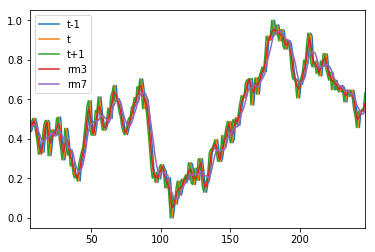

In [9]:
df.plot()
plt.legend(loc='best')

In [10]:
# Membagi data training-testing (xt diganti df)
n_train = round(len(df)*0.90) # jumlah data train 90% dan test 10%

df_x = df.drop(['t+1'], 1)
df_y = df['t+1']

datasetx = np.array(df_x)
datasety = np.array([df_y]).T

X_train = datasetx[:n_train, :]
y_train = datasety[:n_train]
df_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1, sort=True)
train = np.array(df_train)

X_test = datasetx[n_train:, :]
y_test = datasety[n_train:]
df_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1, sort=True)
test = np.array(df_test)

print("Data train = ", train.shape)
print("Data test = ", test.shape)

Data train =  (218, 5)
Data test =  (24, 5)


In [11]:
from datetime import datetime
tic = datetime.now()

## Training section
Data_train = train
N     = len(Data_train)  #Number of observation
Ts    = Data_train.shape[1] - 1   # Time-steps
Ni    = 1   # Input layer dimension
Nh    = 7   # Hidden layer dimension
No    = 1   # Output layer dimension

epochs = 100
alpha  = 1
seed(2020)

# initialize neural network weights
W0    = randn(Ni,Nh)
W1    = randn(Nh,No)
Wh    = randn(Nh,Nh)

dW0   = zeros_like(W0)
dW1   = zeros_like(W1)
dWh   = zeros_like(Wh)

# Compute Sigmoid nonlinearity
Sigmoid = lambda x: 1/(1+exp(-x))

# Convert output of sigmoid function to its derivative
dSigmoid = lambda x: x*(1-x)

# training logic

for n in range(epochs):    
    overallError = 0
    
    deltas2 = []
    S = []
    ycap = []
    S.append(zeros(Nh))
    
    for i in range(N):
        for j in range(Ts):     
            # Forward propagation
            # generate input and output
            X = atleast_2d(Data_train[i][j])
            y = Data_train[i][j+1]
            

            # hidden layer (input + prev_hidden)
            Z1 = X@W0 + S[-1]@Wh
            A1 = Sigmoid(Z1)

            # output layer (new binary representation)
            Z2 = A1@W1
            A2 = Sigmoid(Z2)
            e = y - A2
            deltas2.append(e*dSigmoid(A2))
            overallError += abs(e[0])
            S.append(copy.deepcopy(A1))
            
            
            if n == epochs-1:
                if j == 1:                              
                    #print("Iterasi ke", str(n+1) + ";", "y(t) asli:", y, "| y(t) prediksi:%7.4f" %A2[0][0])
                    ycap.append(A2[0][0])
                    #if i == (N-1):
                        #print("","")
    
        delta1fut = zeros(Nh)   #Prepare the derivative for the future
    
        # Backward propagation
        k1 = Data_train.shape[1] - 3 # k1 = 0 (untuk input=2); k1=1 (untuk input=3); dst
        k2 = k1+1 
        for k in range(Ts):     
            X  = atleast_2d(Data_train[i][-k-Ts+k1]) #Indexing the input data like we did before
            A1 = S[-k-Ts+k2]            #Selecting the current hidden layer
            Sprev = S[-k-Ts+k1]        #Selecting the previous hidden layer
        
            # error at output layer
            delta2 = deltas2[-k-1]      #Selecting the current output error
        
            # error at hidden layer
            delta1 = (delta1fut@Wh.T + delta2@W1.T)*dSigmoid(A1)

            # let's update all our weights so we can try again
            dW1 += atleast_2d(A1).T@delta2
            dWh += atleast_2d(Sprev).T@delta1
            dW0 += X.T@delta1
        
            delta1fut = delta1
    
        W0 += alpha*dW0
        W1 += alpha*dW1
        Wh += alpha*dWh

        dW0 *= 0
        dW1 *= 0
        dWh *= 0
        
toc = datetime.now()

print('Durasi waktunya:',toc-tic)

Durasi waktunya: 0:00:08.933511


In [12]:
cost_train = (y_train-np.array(ycap)).T@(y_train-np.array(ycap))/N #Mean Squared Error (MSE) atau cost function
print ("Akurasi prediksi data train diukur dengan MSE: %9.7f" %cost_train[0][0])

Akurasi prediksi data train diukur dengan MSE: 0.0716636


In [13]:
# Prediksi data test
N     = len(X_test)
Data_train = test

for n in range(epochs):    
    overallError = 0
    
    deltas2 = []
    S = []
    ycap2 = []
    S.append(zeros(Nh))
    
    for i in range(N):
        for j in range(Ts):     
            # Forward propagation
            # generate input and output
            X = atleast_2d(Data_train[i][j])
            y = Data_train[i][j+1]
            

            # hidden layer (input + prev_hidden)
            Z1 = X@W0 + S[-1]@Wh
            A1 = Sigmoid(Z1)

            # output layer (new binary representation)
            Z2 = A1@W1
            A2 = Sigmoid(Z2)
            e = y - A2
            deltas2.append(e*dSigmoid(A2))
            overallError += abs(e[0])
            S.append(copy.deepcopy(A1))
            
            
            if n == epochs-1:
                if j == 1:                              
                    #print("Iterasi ke", str(n+1) + ";", "y(t) asli:", y, "| y(t) prediksi:%7.4f" %A2[0][0])
                    ycap2.append(A2[0][0])
                    #if i == (N-1):
                        #print("","")

In [14]:
N = y_test.shape[0]
cost_test = (y_test-np.array(ycap2)).T@(y_test-np.array(ycap2))/N #Mean Squared Error (MSE) atau cost function
print ("Akurasi prediksi data test diukur dengan MSE: %9.7f" %cost_test[0][0]) # 

Akurasi prediksi data test diukur dengan MSE: 0.0294576


In [15]:
#revert
ytrain_pred = (np.array(ycap) * (x.max()-x.min())) + x.min()
ytrain_act = (y_train * (x.max()-x.min())) + x.min()

ytest_pred = (np.array(ycap2) * (x.max()-x.min())) + x.min()
ytest_act = (y_test * (x.max()-x.min())) + x.min()

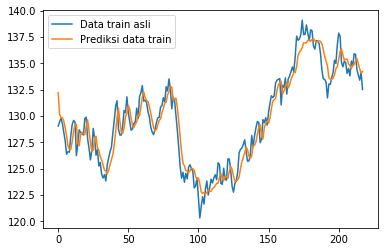

In [16]:
plt.plot(ytrain_act, label='Data train asli')
plt.plot(ytrain_pred, label='Prediksi data train')
plt.legend()
plt.show()

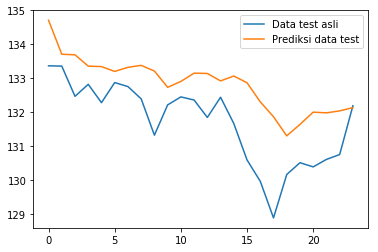

In [17]:
plt.plot(ytest_act, label='Data test asli')
plt.plot(ytest_pred, label='Prediksi data test')
plt.legend()
plt.show()